In [1]:
from matplotlib import pylab as plt

from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
from copy import copy, deepcopy
from torchvision import transforms

import numpy as np

# from tools import * 
# from models import *
# from get_data import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)


In [4]:
# model_save_name = 'resnet_adadelta_last.pkl'
# path = F"/content/gdrive/My Drive/resnet_adadelta_last.pkl" 
adadelta = torch.load(F"/content/gdrive/My Drive/resnet_adadelta_best.pkl")
adam = torch.load(F"/content/gdrive/My Drive/resnet_adam_best.pkl"  )
sgd = torch.load(F"/content/gdrive/My Drive/resnet_sgd_best.pkl")
adahessian_best = torch.load(F"/content/gdrive/My Drive/resnet_adahessian_best.pkl")
adahessian_last = torch.load(F"/content/gdrive/My Drive/resnet_adahessian_last.pkl")

# adadelta = torch.load(F"/content/gdrive/My Drive/resnet_adadelta_best.pkl",map_location='cpu', )
# adam = torch.load(F"/content/gdrive/My Drive/resnet_adam_best.pkl" ,map_location='cpu', )
# sgd = torch.load(F"/content/gdrive/My Drive/resnet_sgd_best.pkl" ,map_location='cpu', )

In [5]:
def getData(name='cifar10', train_bs=128, test_bs=1000):    
    if name == 'svhn':
        train_loader = torch.utils.data.DataLoader(
    datasets.SVHN('../data', split='extra', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=train_bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(
    datasets.SVHN('../data', split='test', download=True,transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=test_bs, shuffle=False)
    if name == 'mnist':
        train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=train_bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=False, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=test_bs, shuffle=False)
    if name == 'emnist':
        train_loader = torch.utils.data.DataLoader(
            datasets.EMNIST('../data', train=True, download=True, split='balanced',
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1751,), (0.3267,))
                           ])),
            batch_size=train_bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(
            datasets.EMNIST('../data', train=False, split='balanced', transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1751,), (0.3267,))
                           ])),
            batch_size=test_bs, shuffle=False)
    if name == 'cifar10':
        transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
        transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
        trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_bs, shuffle=True)
        testset = datasets.CIFAR10(root='../data', train=False, download=False, transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset, batch_size=test_bs, shuffle=False)
    if name == 'cifar100':
        transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
        transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
        trainset = datasets.CIFAR100(root='../data', train=True, download=True, transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_bs, shuffle=True)
        testset = datasets.CIFAR100(root='../data', train=False, download=False, transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset, batch_size=test_bs, shuffle=False)
    if name == 'tinyimagenet':      
        normalize = transforms.Normalize(mean=[0.44785526394844055, 0.41693055629730225, 0.36942949891090393],
                                     std=[0.2928885519504547, 0.28230994939804077, 0.2889912724494934])
        train_dataset = datasets.ImageFolder(
        '../data/tiny-imagenet-200/train',
        transforms.Compose([
            transforms.RandomCrop(64, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_bs, shuffle=True, num_workers=4, pin_memory=False)
        test_dataset = datasets.ImageFolder(
        '../data/tiny-imagenet-200/val',
        transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_bs, shuffle=False)
    return train_loader, test_loader

In [6]:
# T = 28*28

train_loader, test_loader = getData(name='mnist', train_bs=128, test_bs=1000)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
def sp(image, amount):
      row,col = image.shape
      s_vs_p = 0.5
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      idx = np.random.choice(range(28*28), np.int(num_salt), False)
      out = out.reshape(image.size, -1)
      out[idx] = 1.0
      out = out.reshape(28,28)
      
      # Pepper mode
      num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
      idx = np.random.choice(range(28*28), np.int(num_pepper), False)
      out = out.reshape(image.size, -1)
      out[idx] = 1.0
      out = out.reshape(28,28)
      return out

def sp_wrapper(data, amount):
    np.random.seed(12345)
    for i in range(data.shape[0]):
        data_numpy = data[i,0,:,:].data.cpu().numpy()
        noisy_input = sp(data_numpy, amount)
        data[i,0,:,:] = torch.tensor(noisy_input).float().to(device)

    return data 

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Pertubation analysis
def perturb(model, test_loader, noise_level, ntype='white'):
    acc = []
    
    for level in tqdm(noise_level):
        correct = 0
        total_num = 0        
        
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            #print(data.min())
            #print(data.max())
            
            if ntype == 'white':
                np.random.seed(123456)
                data_perturbed = data + torch.randn(data.shape).to(device) * level
                data_perturbed = torch.clamp(data_perturbed, 0, 1)

            elif ntype == 'sp':
                data_perturbed = sp_wrapper(data, level)
                
            output = model(data_perturbed)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            total_num += len(data)
                
        accuracy = correct / total_num
        print(accuracy)
        acc.append(accuracy)
    
    return acc   

In [9]:
# ntype = 'white'
ntype = 'sp'

if ntype == 'white':
    noise_level = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0]
    # noise_level = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    # noise_level = [0.0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25]
    # noise_level = [0.0]
    
else:
    noise_level = [0.0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    # noise_level = [0.0]

start = time.time()

acc_adahessian_best_sp = perturb(adahessian_best, test_loader, noise_level, ntype=ntype)
print(acc_adahessian_best_sp)
acc_adahessian_last_sp = perturb(adahessian_last, test_loader, noise_level, ntype=ntype)
print(acc_adahessian_last_sp)
acc_adadelta_sp = perturb(adadelta, test_loader, noise_level, ntype=ntype)
print(acc_adadelta_sp)
acc_adam_sp = perturb(adam, test_loader, noise_level, ntype=ntype)
print(acc_adam_sp)
acc_sgd_sp = perturb(sgd, test_loader, noise_level, ntype=ntype)
print(acc_sgd_sp)

end = time.time()
print(end - start)


0.9863



0.9861



0.9855



0.9841



0.9834



0.9808



0.9742



0.9642



0.9079



0.7831



0.6161



0.4504



0.3322

[0.9863, 0.9861, 0.9855, 0.9841, 0.9834, 0.9808, 0.9742, 0.9642, 0.9079, 0.7831, 0.6161, 0.4504, 0.3322]



0.9861



0.9858



0.9855



0.9843



0.9838



0.9812



0.9752



0.9656



0.914



0.7964



0.6332



0.457



0.3271

[0.9861, 0.9858, 0.9855, 0.9843, 0.9838, 0.9812, 0.9752, 0.9656, 0.914, 0.7964, 0.6332, 0.457, 0.3271]



0.9953



0.9952



0.9951



0.9939



0.9935



0.9921



0.9846



0.9688



0.9088



0.8058



0.6627



0.4768



0.3091

[0.9953, 0.9952, 0.9951, 0.9939, 0.9935, 0.9921, 0.9846, 0.9688, 0.9088, 0.8058, 0.6627, 0.4768, 0.3091]



0.9937



0.9936



0.9929



0.9924



0.9918



0.9901



0.9817



0.9624



0.8757



0.7495



0.606



0.4563



0.3542

[0.9937, 0.9936, 0.9929, 0.9924, 0.9918, 0.9901, 0.9817, 0.9624, 0.8757, 0.7495, 0.606, 0.4563, 0.3542]



0.9932



0.9931



0.991



0.9897



0.9873



0.9827



0.9728



0.9533



0.89



0.7978



0.7009



0.6088



0.5283

[0.9932, 0.9931, 0.991, 0.9897, 0.9873, 0.9827, 0.9728, 0.9533, 0.89, 0.7978, 0.7009, 0.6088, 0.5283]
406.1298565864563


In [10]:
print(acc_adadelta_sp)
print(acc_adam_sp)
print(acc_sgd_sp)
# acc_adadelta_sp = [0.9925, 0.9929, 0.9924, 0.9912, 0.9903, 0.9885, 0.9843, 0.9791, 0.9553, 0.9037, 0.8246, 0.7053, 0.5738]
# acc_adam_sp = [0.9901, 0.9896, 0.9889, 0.9878, 0.9863, 0.9838, 0.9785, 0.9611, 0.8837, 0.7393, 0.554, 0.3771, 0.2547]
# acc_sgd_sp = [0.992, 0.9918, 0.991, 0.9897, 0.9888, 0.9865, 0.9796, 0.9688, 0.9341, 0.8632, 0.779, 0.6742, 0.5658]
# (acc_adahessian_last_sp) = [0.9861, 0.9858, 0.9855, 0.9843, 0.9838, 0.9812, 0.9752, 0.9656, 0.914, 0.7964, 0.6332, 0.457, 0.3271]

# (acc_adahessian_best_sp) = [0.9863, 0.9861, 0.9855, 0.9841, 0.9834, 0.9808, 0.9742, 0.9642, 0.9079, 0.7831, 0.6161, 0.4504, 0.3322]



[0.9953, 0.9952, 0.9951, 0.9939, 0.9935, 0.9921, 0.9846, 0.9688, 0.9088, 0.8058, 0.6627, 0.4768, 0.3091]
[0.9937, 0.9936, 0.9929, 0.9924, 0.9918, 0.9901, 0.9817, 0.9624, 0.8757, 0.7495, 0.606, 0.4563, 0.3542]
[0.9932, 0.9931, 0.991, 0.9897, 0.9873, 0.9827, 0.9728, 0.9533, 0.89, 0.7978, 0.7009, 0.6088, 0.5283]


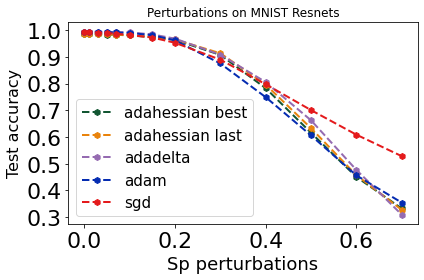

In [12]:
plt.plot(noise_level, acc_adahessian_best_sp, 'h--', lw=2, c='#125632', label='adahessian best')
plt.plot(noise_level, acc_adahessian_last_sp, 'h--', lw=2, c='#e9830c', label='adahessian last')

plt.title("Perturbations on MNIST Resnets") 
plt.plot(noise_level, acc_adadelta_sp, 'h--', lw=2, c='#956bb1', label='adadelta')
plt.plot(noise_level, acc_adam_sp, 'h--', lw=2, c='#052cb1', label='adam')
plt.plot(noise_level, acc_sgd_sp, 'h--', lw=2, c='#e41a1c', label='sgd')
plt.xlabel('Sp perturbations', fontsize=18)
plt.ylabel('Test accuracy', fontsize=16)
plt.tick_params(axis='y', labelsize=22) 
plt.tick_params(axis='x', labelsize=22) 
plt.locator_params(axis='y', nbins=8)  
plt.legend(fontsize=15)  
plt.tight_layout()
plt.show()
# plt.savefig('F"/content/gdrive/My Drive/plot_perturb.pdf')     


In [ ]:
plt.savefig('F"/content/gdrive/My Drive/plot_perturb.pdf')     
